In [1]:
#to reflect changes made in modules
%load_ext autoreload
%autoreload 2

#setup
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import machine_learning

# Project Introduction
The big idea of our project is to  Explore the correlation between gun violence cases with age, location, and/or socioeconomic factors in the area. One main question that we are investigating is has gun reform impacted the number of gun violence cases in the US? We have multiple datasets that show gun-related cases by state and year, firearm laws passed by states, and state populations. The scope of our project is to visualize the number of gun cases in the US using the Gun Violence dataset from the Gun Violence Archive.


# Any Changes
The original scope of the project (mentioned above) has not changed since the previous proposal. The main focus of the project will be about how the number and types of gun reform laws impacts the number of gun violence cases using the datasets on gun cases, gun reform laws, and state population.


- We will **not** identify the correlation between gun violence cases with age and/or socioeconomic factors in each state.
- We will **not** assess the degree of severity of specific gun laws on the number of gun violence cases.
- We added the state population dataset to assess the number of gun cases with correlation to state population.
- We created a decision tree `DecisionTreeClassifier()` and the baseline `MajorityLabelClassifier()` to predict whether the number of gun cases will decrease based on the types of gun reform laws and total laws.

# Data Reading

Because of GitHub storage limits, we could not include our `gun-violence-data_01-2013_03-2018.csv` in this repository. If you would like to run the code below, you will have to download the dataset yourself at https://github.com/jamesqo/gun-violence-data#how-did-you-get-the-data by going to the section "How did you get the data" and following the steps under "stage 3" to download and unpack the tar.gz file. Once you unpack the tar.gz file, you should have a file named stage3.csv. This is the same file as our `gun-violence-data_01-2013_03-2018.csv`, but we renamed the file. You will also have to rename the file from 'stage3.csv' to 'gun-violence-data_01-2013_03-2018.csv'.

In [2]:
# Reading in data for gun violence counts and firearm laws
gun_data = pd.read_csv('gun-violence-data_01-2013_03-2018.csv')
missing_row = ['sban_1', '2017-10-01', 'Nevada', 'Las Vegas', 'Mandalay Bay 3950 Blvd S', 59, 489, 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', '-', '-', '-', '-', '-', '36.095', 'Hotel', 
               '-115.171667', 47, 'Route 91 Harvest Festiva; concert, open fire from 32nd floor. 47 guns seized; TOTAL:59 kill, 489 inj, number shot TBD,girlfriend Marilou Danley POI', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
gun_data.loc[len(gun_data)] = missing_row

gunlaws = pd.read_csv('statefirearmlaws.csv')
gun_laws = pd.DataFrame(data = gunlaws,columns=['state', 'year', 'lawtotal'])

# Data Cleaning

In [3]:
gun_data = pd.read_csv('gun-violence-data_01-2013_03-2018.csv')
missing_row = ['sban_1', '2017-10-01', 'Nevada', 'Las Vegas', 'Mandalay Bay 3950 Blvd S', 59, 489, 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', 'https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting', '-', '-', '-', '-', '-', '36.095', 'Hotel', 
               '-115.171667', 47, 'Route 91 Harvest Festiva; concert, open fire from 32nd floor. 47 guns seized; TOTAL:59 kill, 489 inj, number shot TBD,girlfriend Marilou Danley POI', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
gun_data.loc[len(gun_data)] = missing_row
# Created some additional features
gun_data['date'] = pd.to_datetime(gun_data['date'])
gun_data['year'] = gun_data['date'].dt.year
gun_data['month'] = gun_data['date'].dt.month
gun_data['monthday'] = gun_data['date'].dt.day
gun_data['weekday'] = gun_data['date'].dt.weekday
gun_data['loss'] = gun_data['n_killed'] + gun_data['n_injured']
# Sorted data by state since gun reform data is sorted by state and year in ascending order
gun_data = gun_data.sort_values(['state', 'year'], ascending = [True, True])
# Filtered only cases where the year is between 2014 and 2017
gun_data = gun_data[(gun_data['year'] >= 2014) & (gun_data['year'] <= 2017)]
# Removed some unecessary columns
gun_data = gun_data.drop(columns=['city_or_county','address','source_url','participant_relationship',
                                    'incident_url_fields_missing', 'latitude', 'longitude', 'location_description',
                                    'participant_name', 'sources', 'month', 'monthday', 'weekday', 'loss',
                                   'gun_stolen', 'gun_type', 'n_guns_involved', 'notes'])
# Missing values dropped rows with NaN values
gun_data = gun_data.dropna()
gun_data.head()

,incident_id,date,state,n_killed,n_injured,incident_url,congressional_district,incident_characteristics,participant_age,participant_age_group,participant_gender,participant_status,participant_type,state_house_district,state_senate_district,year
296,92342,2014-01-01,Alabama,1,0,http://www.gunviolencearchive.org/incident/92342,5.0,"Shot - Dead (murder, accidental, suicide)",0::21||1::24,0::Adult 18+||1::Adult 18+,0::Female||1::Male,0::Killed||1::Unharmed,0::Victim||1::Subject-Suspect,19.0,7.0,2014
315,94194,2014-01-01,Alabama,0,3,http://www.gunviolencearchive.org/incident/94194,4.0,Home Invasion||Home Invasion - Resident injure...,3::17||4::19||5::19||6::19,3::Teen 12-17||4::Adult 18+||5::Adult 18+||6::...,0::Male||1::Male||2::Female||3::Male||4::Male|...,0::Injured||1::Injured||2::Injured||3::Unharme...,0::Victim||1::Victim||2::Victim||3::Subject-Su...,61.0,21.0,2014
320,92337,2014-01-01,Alabama,1,0,http://www.gunviolencearchive.org/incident/92337,2.0,"Shot - Dead (murder, accidental, suicide)",0::18||1::19,0::Adult 18+||1::Adult 18+,0::Female||1::Male,0::Killed||1::Unharmed,0::Victim||1::Subject-Suspect,90.0,25.0,2014
383,95279,2014-01-01,Alabama,0,1,http://www.gunviolencearchive.org/incident/95279,4.0,Shot - Wounded/Injured,0::73,0::Adult 18+,0::Female,0::Injured,0::Victim,28.0,10.0,2014
400,92221,2014-01-01,Alabama,1,0,http://www.gunviolencearchive.org/incident/92221,7.0,"Shot - Dead (murder, accidental, suicide)",0::36,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Killed||1::Unharmed,0::Victim||1::Subject-Suspect,52.0,18.0,2014


We processed our data by filtering out the necessary rows and columns based on the year range that best applied to all of our datasets, missing values, and features that most directly impact our EDA. We applied this process to all of our datasets (gun violence, state firearm laws, gun reform). 

# Exploratory Data Analysis
The datasets that we are using contain information about gun violence incidents from 2013-2018, gun reform laws from 1991-2020, and state populations from 2010-2019. The Gun Violence dataset indicates that there has been an increase in gun violence from 2014 to 2017. Additionally, there has been an overall increase in gun reform laws across the US, which led us to explore whether gun reform laws have an impact on gun violence at the state level.

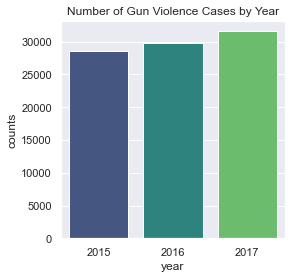

In [4]:
gun_data['date'] = pd.to_datetime(gun_data['date'])
gun_data['year'] = gun_data['date'].dt.year
gun_data_year = gun_data
gun_data_year = gun_data_year.groupby(['year']).size().reset_index(name='counts')

sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x="year", y="counts", data=gun_data_year.loc[1:4, :], palette='viridis')

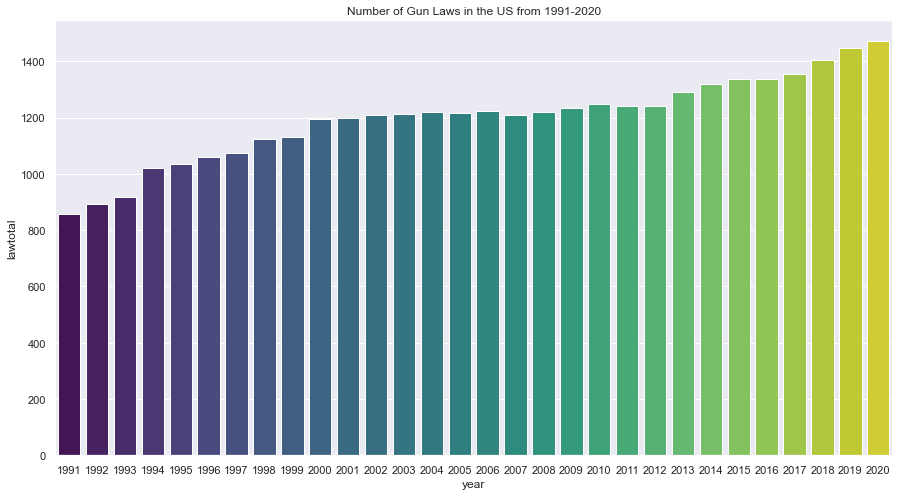

In [5]:
gun_laws_year = gun_laws.groupby(['year']).sum().reset_index()
sns.set(rc = {'figure.figsize':(15,8)});
sns.barplot(x='year', y='lawtotal', data=gun_laws_year, palette='viridis').set(title='Number of Gun Laws in the US from 1991-2020');

# At least one visualization that tests an interesting hypothesis


The hypothesis that we will be testing is that states with more strict gun laws have a smaller amount of gun violence incidents compared to states with less strict gun laws.

,state,counts
13,Illinois,12845
4,California,8087
9,Florida,7387
32,New York,6881
35,Ohio,5607


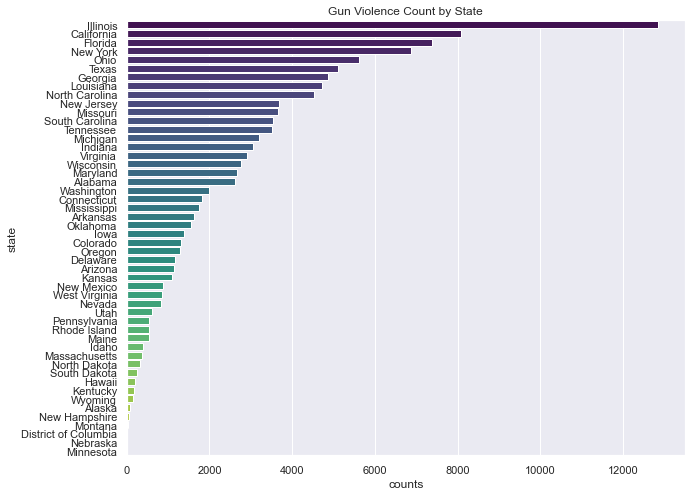

In [6]:
df_state = gun_data.groupby(['state']).size().reset_index(name='counts')
df_state = df_state.sort_values(by='counts', ascending=False)
sns.set(rc = {'figure.figsize':(10,8)})
sns.barplot(x='counts', y='state', data=df_state, palette='viridis').set(title="Gun Violence Count by State");

df_state.head()

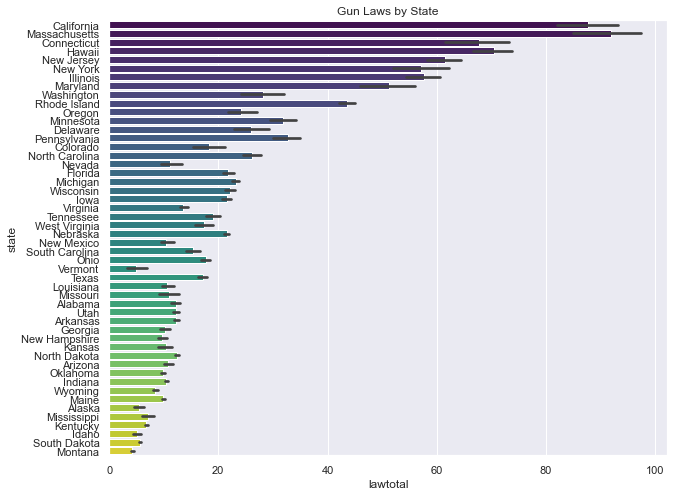

In [7]:
df_laws = gun_laws.sort_values(by='lawtotal', ascending=False)
sns.set(rc = {'figure.figsize':(10,8)})
sns.barplot(x='lawtotal', y='state', data=df_laws, palette='viridis').set(title="Gun Laws by State");

Looking at the visualizations, Illinois has the highest gun violence incidents and Hawaii has the least number of incidents. However, the population difference is very large. Because of this, we will calculate a proportion that represents (# of cases/ population). 


In [8]:
uspopulation = pd.read_csv('us_states_census.csv') 
population = pd.DataFrame(data=uspopulation, columns=['state','2013','2014','2015','2016','2017', '2018'])

state_cases = gun_data.groupby(['state']).size().reset_index(name='counts')
state_cases = state_cases.sort_values(by='state', ascending=True)
state_cases['population'] = population['2018']

prop_cases = population
prop_cases['prop_cases'] = state_cases['counts'] / population['2018']
prop_cases = prop_cases.sort_values(by=['prop_cases'], ascending=False)
print(prop_cases.head(2))
print(prop_cases.tail(1))

            state       2013       2014       2015       2016       2017  \
45        Vermont   626210.0   625214.0   625216.0   623657.0   624344.0   
48  West Virginia  1853914.0  1849489.0  1842050.0  1831023.0  1817004.0   

         2018  prop_cases  
45   624358.0    0.004640  
48  1804291.0    0.001535  
      state      2013      2014      2015      2016      2017      2018  \
50  Wyoming  582122.0  582531.0  585613.0  584215.0  578931.0  577601.0   

    prop_cases  
50         NaN  


Looking at the new proportion calculations, we will compare the proportion of cases between **District of Columbia** and **Hawaii** and if the number of laws affects the proportion.


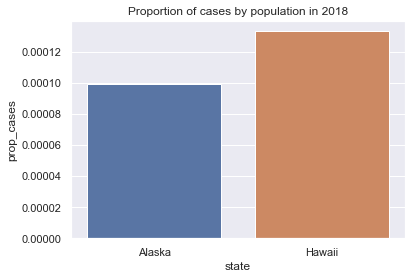

In [9]:
top_state_inc = pd.DataFrame(population[population['state'] == 'Alaska'])
low_state_inc = pd.DataFrame(population[population['state'] =='Hawaii'])

list_states_inc = [top_state_inc, low_state_inc]
stats_inc = pd.concat(list_states_inc)
stats_inc
sns.set(rc = {'figure.figsize':(6,4)});
sns.barplot(data=stats_inc, x="state", y="prop_cases").set(title="Proportion of cases by population in 2018");


In Alaska, roughly 3 laws were passed each year between 2013 and 2018, and the proportion of cases by population is 0.001835. In Hawaii, roughly 79-80 laws were added by 2018. There is a lower proportion, 0.000203. 

# Hypothesis Results

Our hypothesis is correct. Alaska has one of the  highest proportions of gun-related incidents by population, but a lower number of gun laws. Hawaii has a lower proportion of gun-related incidents by population, and a higher number of gun laws passes. Given that our hypothesis was that states with low gun-related incidents have higher gun laws, and vice versa, our hypothesis was correct. 

In [10]:
import scipy
df_states = pd.read_csv('df_states.csv')
stat, p = scipy.stats.pearsonr(df_states['per_counts'], df_states['lawtotal'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('There is not enough evidence to reject H0. Probably independent')
else:
	print('There is enough evidence to reject H0. Probably dependent')
# law_tatoal vs. gun_violence_counts per 10000 people

stat=-0.183, p=0.204
There is not enough evidence to reject H0. Probably independent


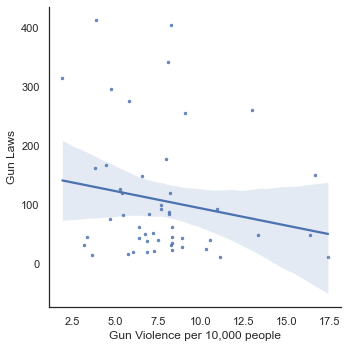

In [11]:
sns.set_style('white')
ax = sns.lmplot(x="per_counts", y="lawtotal", data=df_states, scatter_kws={'s': 6}, legend=True)
ax.set(ylabel="Gun Laws")
ax.set(xlabel="Gun Violence per 10,000 people");

# ML Analysis: Decision Tree
on your dataset, along with a baseline comparison and an interpretation of the result that you obtain. 

In [12]:
#clean and merge data set for ML 
gun_cases = 'gun-violence-data_01-2013_03-2018.csv'
gun_laws = 'statefirearmlaws.csv'
population = 'us_states_census.csv'
data = machine_learning.combineDatasets(gun_cases, gun_laws, population)
data.head(5)

,state,year,proportion_harmed,decrease_in_gun_violence,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
0,Alabama,2015,0.000195,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
1,Alabama,2016,0.000257,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
2,Alabama,2017,0.000287,False,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,10
3,Alaska,2015,0.000209,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,Alaska,2016,0.000258,False,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [13]:
#create features and labels for ML application. Label is (0,1) based on 
#whether a decrease in gun_violence was observed
X, y = machine_learning.create_features_labels(data)

### More about the target variable: `decrease_in_gun_violence`

`decrease_in_gun_violence` is measured by comparing the proportion of people harmed (killed or injured) 
for a state's current and previous years from the time frame of 2014-2017. Thus, each state in our data set `data` has an entry for 2015, 2016, and 2017. 

Using Alabama as an example of how we determine the target variable for each state+year, there are three entries in our dataset: Alabama 2015, Alabama 2016, and Alabama 2017. 
Alabama 2015's value for `decrease_in_gun_violence` is determined by looking at the proportion of people harmed in the previous year, Alabama 2014, and the proportion of people harmed in the current row's year, Alabama 2015. If there is a decrease in proportion of people harmed then `decrease_in_gun_violence=True`. Otherwise `decrease_in_gun_violence=False`. The same process is repeated to get target variable values for Alabama 2016 and Alabama 2017. 

We calculate the proportion of people harmed as a raw count divided by the population for that state+year to account for increases/decreases in population affecting the rate of gun violence in a state at a given year. 

In [14]:
#the proportion of classes w.r.t 'decrease_in_gun_violence' (0,1) is unbalanced
print(f'Number of examples in our entire dataset where decrease_in_gun_violence=0: {len(y[y == 0])}')
print(f'Number of examples in our entire dataset where decrease_in_gun_violence=1: {len(y[y == 1])}')

Number of examples in our entire dataset where decrease_in_gun_violence=0: 101
Number of examples in our entire dataset where decrease_in_gun_violence=1: 49


In [15]:
#building our baseline classifier (predicts the majority label)
baseline = machine_learning.MajorityLabelClassifier()
baseline.fit(X, y)
labels = baseline.predict(X)
print(baseline.evaluate_accuracy(y, labels))

0.6838235294117647


Train Accuracy: 0.8866666666666667
Test Accuracy: 0.43333333333333335
precision: [0.73333333 0.13333333]
recall   : [0.45833333 0.33333333]
f1 score : [0.56410256 0.19047619]


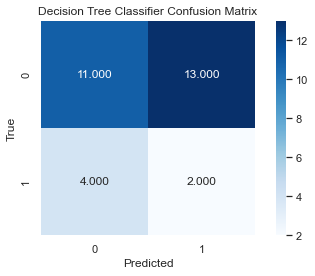

In [16]:
#evaluating our Decision Tree classifier by training, fitting, and predicting on our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1) #changed split to 80% train, 20% test

decision_tree = machine_learning.DecisionTree()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

decision_tree.display_metrics(X, y, y_test, y_pred)

# Reflection
`A discussion of the following:`
- `What is the hardest part of the project that you’ve encountered so far?`
- `What are your initial insights?`
- `Are there any concrete results you can show at this point? If not, why not?`
- `Going forward, what are the current biggest problems you’re facing?`
- `Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?`
- `Given your initial exploration of the data, is it worth proceeding with your project, why? If not, how are you going to change your project and why do you think it’s better than your current results?`



The hardest part of the project that we've encountered so far would be trying to incorporate a robust machine learning model with our dataset. Coming up with the features that would yield a good prediction as to whether gun violence would decrease with information about proportion of individuals harmed, as well as gun reform information, turns out to be quite difficult on its own. 

Our initial insights from this project at this stage mainly center around the idea that predicting trends in gun violence is a complex problem in itself, due to various socioeconomic factors, as well as gun reform implemented. Gun violence also tends to be motivated by a myriad of different factors at the individual suspect level, so attributing what causes gun violence is incredibly difficult to predict to an exact degree.

At this point, there are no concrete results we can show, as our model seems to yield inconclusive results on whether we can predict trends in gun violence rates from gun reform data. This 
inconclusivity can be due to our imbalanced dataset, which is biased in the sense that there are more instances of cases where gun violence did NOT decrease than the opposite. Going forward, our team will need to decide how to address this issue, as well as what other possible features we can create/extract from our data to try and increase our model's predictive performance. 

At this stage, our team is on track with our project. The next stage would place a heavier emphasis on tuning our model by incorporating cross validation, tree pruning, and additional features to try and improve prediction performance on test data. Our team speculates that incorporating all of the aforementioned factors would help our decision tree generalize better to unseen test data, and avoid the current scenario of our decision tree classifier overfitting on our train data. The cross validation has the potential to help us tune hyperparameters that go into building our decision tree, which can increase the performance of our classifier. 

# Next Steps
`What you plan to accomplish in the next month and how you plan to evaluate whether your project achieved the goals you set for it.`


In the next month, our team plans to implement the following methods to achieve a better accuracy, precision, recall, and f1 score for our decision tree: 

- using cross validation to tune decision tree hyperparameters
- pruning the tree to try and avoid overfitting
- handle class imbalances in data
- add additional features about participant info such as mean participant age, mean victim age, mean suspect age on a per state/year basis


## Deliverables: a PDF of your jupyter notebook, with a link to the notebook located in your repository; Notebook can’t be more than 5 pages